In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Download model

In [2]:
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

100% 241M/242M [00:08<00:00, 33.4MB/s]
100% 242M/242M [00:08<00:00, 29.1MB/s]


In [3]:
#Unzip file
import zipfile
zip_ref=zipfile.ZipFile('/content/5-flower-types-classification-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

#Load images

In [5]:
data_dir='/content/flower_images'

In [6]:
class_names=os.listdir(data_dir)

In [7]:
image_exts=['jpeg','jpg','bmp','png']
image_exts[2]

'bmp'

In [8]:
#Read images from directory
img=os.listdir(os.path.join(data_dir,'Lilly'))


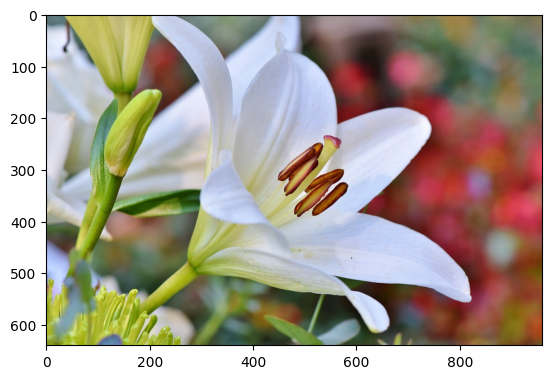

In [9]:
img1=cv2.imread(os.path.join(data_dir,'Lilly','001ff6656j.jpg'))
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

#Divide images into train and validation

In [10]:
#generator
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/flower_images',
    validation_split=0.2,
    subset='training',
    seed=123,
    batch_size=32,
    image_size=(180,180)
)

Found 4999 files belonging to 5 classes.
Using 4000 files for training.


In [11]:
val_ds=keras.utils.image_dataset_from_directory(
    directory='/content/flower_images',
    validation_split=0.2,
    subset='validation',
    seed=123,
    batch_size=32,
    image_size=(180,180))

Found 4999 files belonging to 5 classes.
Using 999 files for validation.


In [12]:
class_names=train_ds.class_names
print(class_names)

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


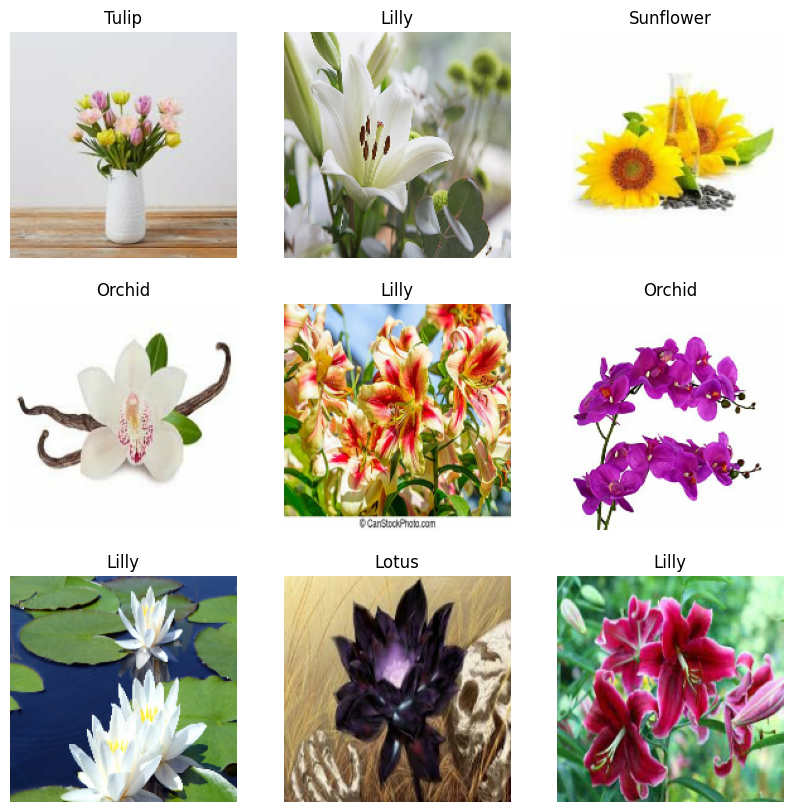

In [13]:
plt.figure(figsize=(10,10))
for images,labels in val_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

#Normalizing

In [14]:
#Normalizing
def process(image,label):
  image=tf.cast(image/255.,tf.float32)
  return image,label
train_ds = train_ds.map(process)
val_ds= val_ds.map(process)

In [15]:
model=Sequential()

In [16]:
model.add(Conv2D(32,(3,3),1,activation='relu',input_shape=(180,180,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(5,activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)       0

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Model train

In [19]:
model.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
125/125 [==============================] - 18s 92ms/step - loss: 1.3078 - accuracy: 0.4675 - val_loss: 1.1270 - val_accuracy: 0.5626
Epoch 2/10
125/125 [==============================] - 12s 90ms/step - loss: 1.0055 - accuracy: 0.6050 - val_loss: 1.0097 - val_accuracy: 0.6086
Epoch 3/10
125/125 [==============================] - 14s 108ms/step - loss: 0.7703 - accuracy: 0.6975 - val_loss: 0.8368 - val_accuracy: 0.6877
Epoch 4/10
125/125 [==============================] - 12s 91ms/step - loss: 0.4658 - accuracy: 0.8372 - val_loss: 0.7335 - val_accuracy: 0.7558
Epoch 5/10
125/125 [==============================] - 12s 91ms/step - loss: 0.2523 - accuracy: 0.9145 - val_loss: 0.8364 - val_accuracy: 0.7718
Epoch 6/10
125/125 [==============================] - 12s 92ms/step - loss: 0.1505 - accuracy: 0.9520 - val_loss: 0.9940 - val_accuracy: 0.7578
Epoch 7/10
125/125 [==============================] - 11s 87ms/step - loss: 0.1251 - accuracy: 0.9625 - val_loss: 0.8254 - val_accuracy

#Model save

In [22]:
model.save('flower_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Streamlit app

In [1]:
import streamlit as st
from PIL import Image
import numpy as np

# Define your predict function
def predict_image(img):
    # Preprocess the image
    img = np.array(img.resize((180, 180))) / 255.0  # Resize and normalize the image
    img = img.reshape(-1, 180, 180, 3)
    # Perform prediction
    prediction = model.predict(img)[0]
    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction)
    # Get the corresponding class name
    predicted_class = class_names[predicted_class_index]
    # Return the predicted class name and its associated probability
    return predicted_class, float(prediction[predicted_class_index])

# Load your trained model and define the class_names
# Replace 'your_model' with your actual trained model
class_names = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']  # Replace with your class names

# Streamlit interface
st.title("Flower Classification")
uploaded_image = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_image is not None:
    image = Image.open(uploaded_image)
    st.image(image, caption="Uploaded Image", use_column_width=True)
    st.write("")
    st.write("Classifying...")
    predicted_class, confidence = predict_image(image)
    st.write(f"Prediction: {predicted_class}, Confidence: {confidence:.2f}")

